## Import Statements

In [24]:
import numpy as np
import cv2
import sys
import glob
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn import grid_search
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label

## Load And Augment Data
Perform a horizontal flip on all data to double the amount of training data

In [25]:
#Read Files
car = glob.glob('train_data/vehicles/**/*.png')
non_car = glob.glob('train_data/non-vehicles/**/*.png')

car_images = []
non_car_images = []

#Save Images and flipped images
for file in car:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    flip_image = cv2.flip(image, 1)
    car_images.append(image)
    car_images.append(flip_image)
    
for file in non_car:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    flip_image = cv2.flip(image, 1)
    non_car_images.append(image)
    non_car_images.append(flip_image)

image_data = {"car_images" : car_images,
              "non_car_images" : non_car_images}

pickle.dump(image_data, open("pickles/image_data.p", "wb"))
print("Image data saved to \"image_data.p\"")

Image data saved to "image_data.p"


## Define Functions for Feature Extraction
Most of this code is from or has been slightly adatped from the code provided in the lessons.

In [26]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=9,
                        pix_per_cell=8, cell_per_block=2):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(image_lab, size=spatial_size)
        # Apply color_hist() also with a color space option now
        
        hist_features = color_hist(image_hsv, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list

        hog_features = []
        for channel in range(image_yuv.shape[2]):
            hog_features.append(get_hog_features(image_yuv[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        

        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        #features.append(hog_features)
    # Return list of feature vectors
    return features


## Train Classifier
This code has been slightly adapted from the code provided in the lessons.

In [28]:
spatial = 16
histbin = 44
orient = 17
ppc = 8
cpb = 2

car_features = extract_features(car_images, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), pix_per_cell = ppc,
                        cell_per_block = cpb, orient=orient)
notcar_features = extract_features(non_car_images, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), pix_per_cell = ppc,
                        cell_per_block = cpb, orient=orient)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
video_classifier = {'svc': svc,
                   'X_scaler': X_scaler}
pickle.dump(video_classifier, open("pickles/VideoClassifier_17.p", "wb"))

Using spatial binning of: 16 and 44 histogram bins
Feature vector length: 10896
6.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9945
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  1.  1.]
0.00301 Seconds to predict 10 labels with SVC


## Define Function to Find Cars
This code has been adapted from the code provided in the lessons

In [29]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch_lab = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LAB)
    ctrans_tosearch_hsv = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    ctrans_tosearch_yuv = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = ctrans_tosearch_lab.shape
        ctrans_tosearch_lab = cv2.resize(ctrans_tosearch_lab, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        ctrans_tosearch_hsv = cv2.resize(ctrans_tosearch_hsv, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        ctrans_tosearch_yuv = cv2.resize(ctrans_tosearch_yuv, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch_yuv[:,:,0]
    ch2 = ctrans_tosearch_yuv[:,:,1]
    ch3 = ctrans_tosearch_yuv[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    detection_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg_lab = cv2.resize(ctrans_tosearch_lab[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg_hsv = cv2.resize(ctrans_tosearch_hsv[ytop:ytop+window, xleft:xleft+window], (64,64))
        
            # Get color features
            spatial_features = bin_spatial(subimg_lab, size=(spatial_size, spatial_size))
            hist_features = color_hist(subimg_hsv, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                detection_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return detection_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Test the Pipline on Images

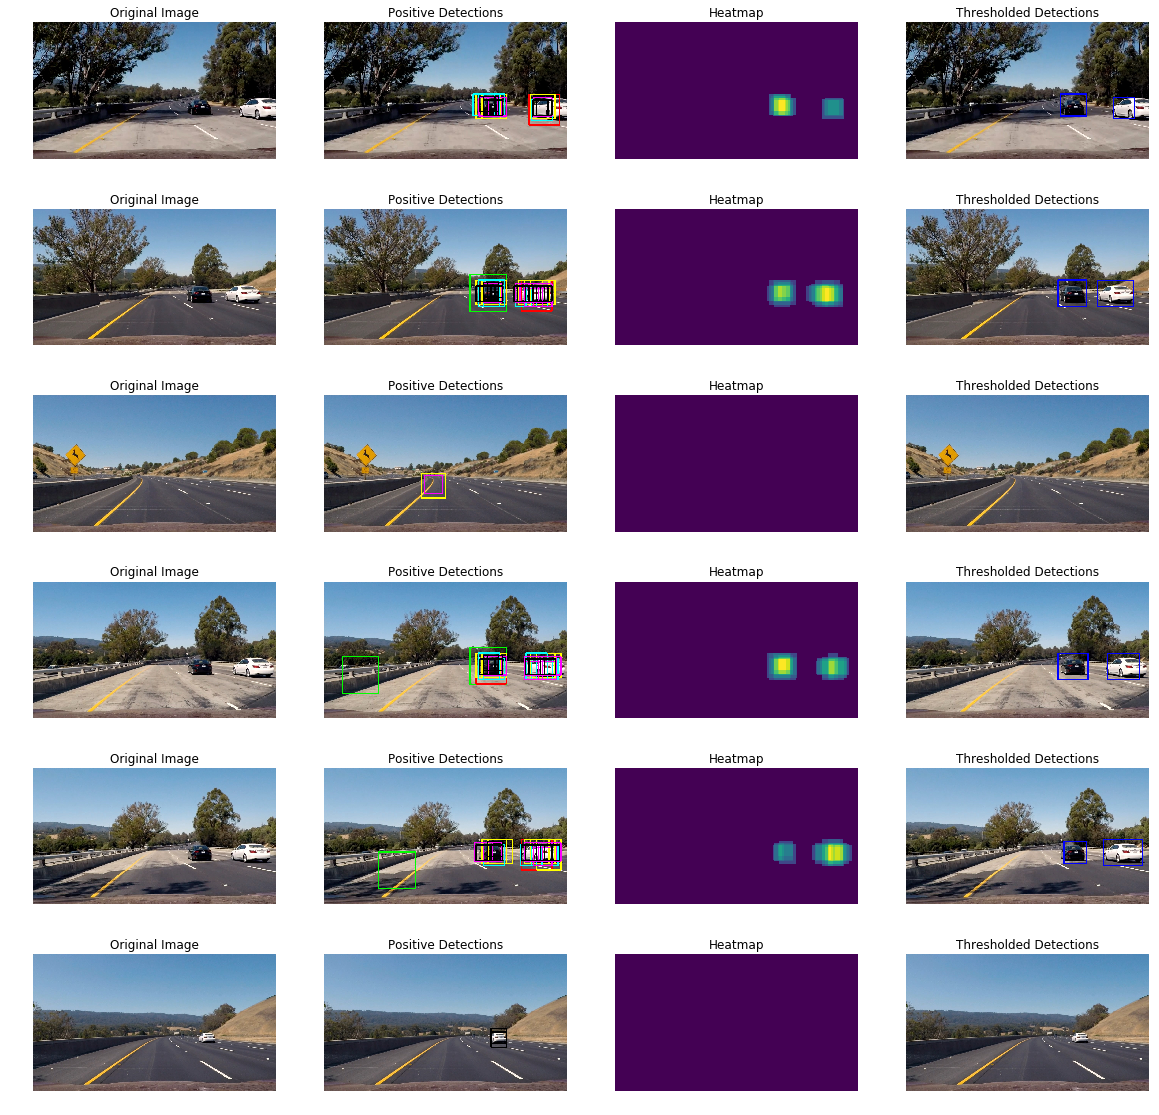

In [30]:
test_files = glob.glob('test_images/*.jpg')
test_images = []

for file in test_files:
    test_images.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))

detected_imgs = []
counter = 1
fig_6 = plt.figure(figsize=(20,20))

for image in test_images:
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    detection_list_0 = find_cars(image, ystart=350, ystop=720, scale=3.5, svc=svc, X_scaler=X_scaler, orient=17,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detected0 = draw_boxes(image, detection_list_0, color=(0, 0, 255), thick=6)
    
    detection_list_1 = find_cars(image, ystart=350, ystop=720, scale=3, svc=svc, X_scaler=X_scaler, orient=17,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detected1 = draw_boxes(detected0, detection_list_1, color=(0, 255, 0), thick=6)
    
    detection_list_2 = find_cars(image, ystart=380, ystop=720, scale=2.5, svc=svc, X_scaler=X_scaler, orient=17,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detected2 = draw_boxes(detected1, detection_list_2, color=(255, 0, 0), thick=6)
    
    detection_list_3 = find_cars(image, ystart=380, ystop=720, scale=2, svc=svc, X_scaler=X_scaler, orient=17,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detected3 = draw_boxes(detected2, detection_list_3, color=(255, 255, 0), thick=6)
        
    detection_list_4 = find_cars(image, ystart=350, ystop=550, scale=1.75, svc=svc,X_scaler=X_scaler, orient=17,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detected4 = draw_boxes(detected3, detection_list_4, color=(0, 255, 255), thick=6)
    
    detection_list_5 = find_cars(image, ystart=350, ystop=630, scale=1.5, svc=svc,X_scaler=X_scaler, orient=17,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detected5 = draw_boxes(detected4, detection_list_5, color=(255, 0, 255), thick=6)
    
    detection_list_6 = find_cars(image, ystart=350, ystop=520, scale=1.25, svc=svc,X_scaler=X_scaler, orient=17,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detected6 = draw_boxes(detected5, detection_list_6, color=(0, 0, 0), thick=6)
    
    windows = detection_list_0 + detection_list_1 + detection_list_2 + detection_list_3 + \
                detection_list_4 + detection_list_5 + detection_list_6
    
    heatmap = add_heat(heatmap, windows)
    heatmap = apply_threshold(heatmap, 2)
    heatmap_clip = np.clip(heatmap, 0, 255)
    labels = label(heatmap_clip)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    fig_6.add_subplot(6,4,counter)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(image)
    fig_6.add_subplot(6,4,counter+1)
    plt.title('Positive Detections')
    plt.axis('off')
    plt.imshow(detected6)
    fig_6.add_subplot(6,4,counter+2)
    plt.title('Heatmap')
    plt.axis('off')
    plt.imshow(heatmap)
    fig_6.add_subplot(6,4,counter+3)
    plt.title('Thresholded Detections')
    plt.axis('off')
    plt.imshow(draw_img)
    counter+=4

plt.savefig('output_images/pipeline_17.png')
plt.show()

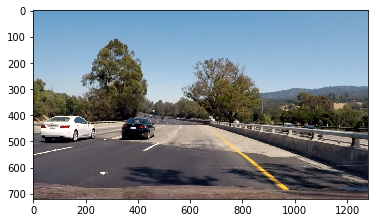

In [16]:
plt.imshow(cv2.flip(test_images[4], 1))
plt.show()

In [40]:
def process_frame(frame):
    heatmap = np.zeros_like(frame[:,:,0]).astype(np.float)
    
    detection_list = find_cars(frame, ystart=350, ystop=720, scale=3.5, svc=svc, X_scaler=X_scaler, orient=9,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detection_list = find_cars(frame, ystart=350, ystop=720, scale=3, svc=svc, X_scaler=X_scaler, orient=9,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detection_list = find_cars(frame, ystart=380, ystop=720, scale=2.5, svc=svc, X_scaler=X_scaler, orient=9,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detection_list += find_cars(frame, ystart=380, ystop=720, scale=2, svc=svc, X_scaler=X_scaler, orient=9,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detection_list += find_cars(frame, ystart=350, ystop=630, scale=1.75, svc=svc, X_scaler=X_scaler, orient=9,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
        
    detection_list += find_cars(frame, ystart=390, ystop=550, scale=1.5, svc=svc,X_scaler=X_scaler, orient=9,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)
    
    detection_list += find_cars(frame, ystart=390, ystop=500, scale=1.25, svc=svc,X_scaler=X_scaler, orient=9,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)

    detection_list += find_cars(frame, ystart=380, ystop=500, scale=1, svc=svc,X_scaler=X_scaler, orient=9,
                                 pix_per_cell = 8, cell_per_block = 2, spatial_size= 16, hist_bins=44)

    
    if (len(detection_list)) > 0:
        prev_det.add_detections(detection_list)
    else:
        prev_det.add_detections([])
    

    threshold = 2 + 2*len(prev_det.previous_detections)
    
    for detections in prev_det.previous_detections:
        if (len(detections) > 0):
            heatmap = add_heat(heatmap, detections)
    
    heatmap = apply_threshold(heatmap, threshold)
    heatmap_clip = np.clip(heatmap, 0, 255)
    labels = label(heatmap_clip)
    draw_img = draw_labeled_bboxes(np.copy(frame), labels)
    
    return draw_img

class Vehicle_Detections():
    def __init__(self):
        self.previous_detections = []
        
    def add_detections(self, detections):
        
        self.previous_detections.append(detections)
        
        if len(self.previous_detections) > 10:
            self.previous_detections.pop(0)

In [41]:
classifier = pickle.load(open("pickles/VideoClassifier.p", "rb"))
svc = classifier["svc"]
X_scaler = classifier["X_scaler"]
                         
prev_det = Vehicle_Detections()
video_1_output = 'video_output/project_final.mp4'
video_1 = VideoFileClip("project_video.mp4")
video_clip = video_1.fl_image(process_frame)
%time video_clip.write_videofile(video_1_output, audio=False)

[MoviePy] >>>> Building video video_output/project_final.mp4
[MoviePy] Writing video video_output/project_final.mp4



100%|█████████▉| 1260/1261 [25:19<00:01,  1.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_final.mp4 

CPU times: user 52min 9s, sys: 3.67 s, total: 52min 13s
Wall time: 25min 19s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_1_output))